## Importing Packages

In [ ]:
pip install ISLP

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
 

In [ ]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots

In [ ]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize, poly)

## Simple Regression Model

Regression model to predict median house value of a neighborhood based on 13 predictors. The first simple regression model will use ```lstat``` (% of households with low SES) to predict ```medv```.



In [ ]:
# load data
Boston = load_data("Boston")
# model matrix
X = pd.DataFrame({'intercept':np.ones(Boston.shape[0]),
                  'lstat':Boston['lstat']})
X[:4]
# extract response
y = Boston['medv']
model1 = sm.OLS(y, X)
results = model1.fit()
summarize(results)

,coef,std err,t,P>|t|
intercept,34.5538,0.563,61.415,0.0
lstat,-0.9500,0.039,-24.528,0.0


### Fit and Transform
Transform in sklearn is an object created with some parameters as arguements. Mainly for data preprocessing and specifying interactions. ```fit()``` takes original array and may do initial computations for centering and scaling while ```transform()``` applise fitted transformation to array and produces model matrix.

In [ ]:
design = MS(['lstat'])
X = design.fit_transform(Boston)
X[:4]

,intercept,lstat
0,1.0,4.98
1,1.0,9.14
2,1.0,4.03
3,1.0,2.94


In [ ]:
new_df = pd.DataFrame({'lstat':[5, 10, 15]})
newX = design.transform(new_df)
new_predictions = results.get_prediction(newX)
print(f"Predictions: {new_predictions.predicted_mean}\n")
print(f"Predictions CI: {new_predictions.conf_int(alpha=0.05)}\n")
print(f"Predictions PI: {new_predictions.conf_int(obs=True, alpha = 0.05)}\n")

Predictions: [29.80359411 25.05334734 20.30310057]

Predictions CI: [[29.00741194 30.59977628]
 [24.47413202 25.63256267]
 [19.73158815 20.87461299]]

Predictions PI: [[17.56567478 42.04151344]
 [12.82762635 37.27906833]
 [ 8.0777421  32.52845905]]



## Defining Functions

<ipython-input-18-7d50f2af97ff>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  abline(ax, results.params[0], results.params[1], 'r--', linewidth = 3)


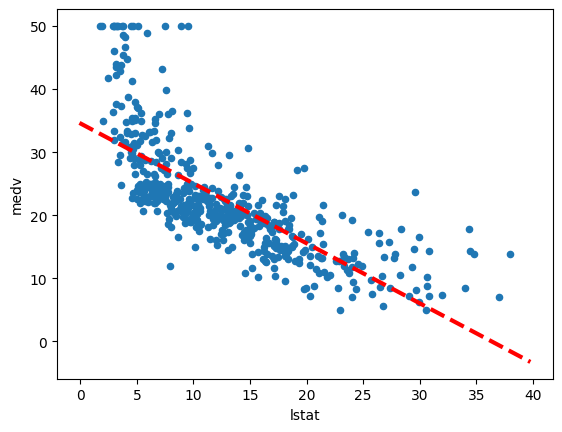

In [ ]:
def abline(ax, b, m, *args, **kwargs):
  xlim = ax.get_xlim()
  ylim = [m * xlim[0] + b, m * xlim[1] + b]
  ax.plot(xlim, ylim, *args, **kwargs)

ax = Boston.plot.scatter('lstat', 'medv')
abline(ax, results.params[0], results.params[1], 'r--', linewidth = 3)

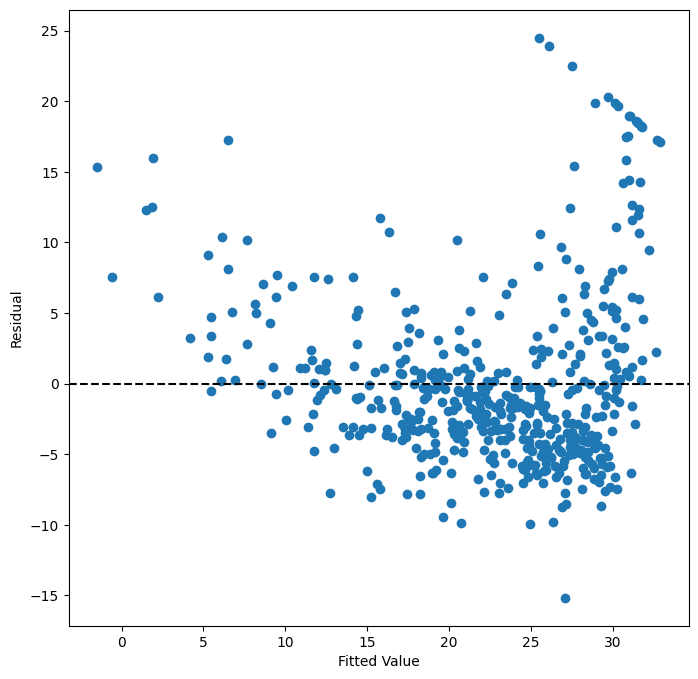

In [ ]:
ax = subplots(figsize = (8,8))[1]
ax.scatter(results.fittedvalues, results.resid)
ax.set_xlabel('Fitted Value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--')


Residual plot shows some basis for non-linearity.

374

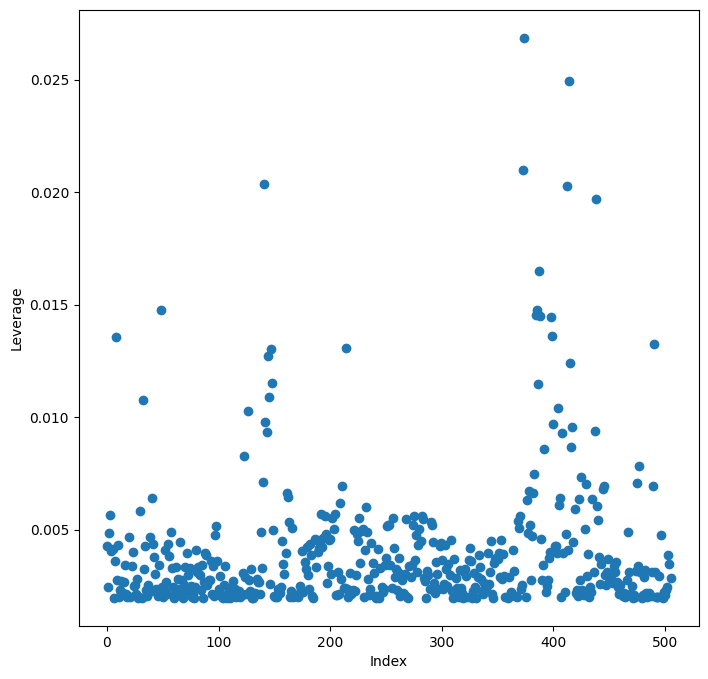

In [ ]:
infl = results.get_influence()
ax = subplots(figsize = (8,8))[1]
ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
np.argmax(infl.hat_matrix_diag)

Leverage statistics are a measure of how much an observation affects a regression model. They are used to identify observations that are far from the rest of the data, which can be influential on the model.

## Multiple Linear Regression

In [ ]:
X = MS(['lstat', 'age']).fit_transform(Boston)
model2 = sm.OLS(y, X)
results2 = model2.fit()
summarize(results2)

,coef,std err,t,P>|t|
intercept,33.2228,0.731,45.458,0.000
lstat,-1.0321,0.048,-21.416,0.000
age,0.0345,0.012,2.826,0.005


In [ ]:
terms = Boston.columns.drop('medv')
X = MS(terms).fit_transform(Boston)
model3 = sm.OLS(y, X)
results3 = model3.fit()
summarize(results3)

,coef,std err,t,P>|t|
intercept,41.6173,4.936,8.431,0.000
crim,-0.1214,0.033,-3.678,0.000
zn,0.0470,0.014,3.384,0.001
indus,0.0135,0.062,0.217,0.829
chas,2.8400,0.870,3.264,0.001
nox,-18.7580,3.851,-4.870,0.000
rm,3.6581,0.420,8.705,0.000
age,0.0036,0.013,0.271,0.787
dis,-1.4908,0.202,-7.394,0.000
rad,0.2894,0.067,4.325,0.000


In [ ]:
vals = []
for i in range(1, X.values.shape[1]):
  vals.append(VIF(X.values, i))
vif = pd.DataFrame({'vif':vals},
                   index = X.columns[1:])
vif

,vif
crim,1.767486
zn,2.298459
indus,3.987181
chas,1.071168
nox,4.369093
rm,1.912532
age,3.088232
dis,3.954037
rad,7.445301
tax,9.002158


### Interaction Terms

In [ ]:
X = MS(['lstat', 'age', ('lstat', 'age')]).fit_transform(Boston)
model4 = sm.OLS(y, X)
summarize(model4.fit())

,coef,std err,t,P>|t|
intercept,36.0885,1.470,24.553,0.000
lstat,-1.3921,0.167,-8.313,0.000
age,-0.0007,0.020,-0.036,0.971
lstat:age,0.0042,0.002,2.244,0.025


### Non-linear Transformations

In [ ]:
X = MS([poly('lstat', degree=2), 'age']).fit_transform(Boston)
model5 = sm.OLS(y, X)
summarize(model5.fit())

,coef,std err,t,P>|t|
intercept,17.7151,0.781,22.681,0.0
"poly(lstat, degree=2)[0]",-179.2279,6.733,-26.620,0.0
"poly(lstat, degree=2)[1]",72.9908,5.482,13.315,0.0
age,0.0703,0.011,6.471,0.0


p-value of quadratic term suggests improvement. Also from the residual plot we know that this relationship may be non-linear. ```anova_lm()``` further quantifies extent to which quadratic is superior to linear fit.

In [ ]:
anova_lm(results2, model5.fit())

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,503.0,19168.128609,0.0,NaN,NaN,NaN
1,502.0,14165.613251,1.0,5002.515357,177.278785,7.468491e-35


Here results1 represents the linear submodel containing predictors lstat
and age, while results3 corresponds to the larger model above with a
quadratic term in lstat. The anova_lm() function performs a hypothesis
test comparing the two models. The null hypothesis is that the quadratic
term in the bigger model is not needed, and the alternative hypothesis is
that the bigger model is superior. Here the F-statistic is 177.28 and the
associated p-value is zero. In this case the F-statistic is the square of the
t-statistic for the quadratic term in the linear model summary for results3
— a consequence of the fact that these nested models difer by one degree of freedom. This provides very clear evidence that the quadratic polynomial
in lstat improves the linear model. This is not surprising, since earlier we
saw evidence for non-linearity in the relationship between medv and lstat.

## Qualitative Predictors

Predict sales of child car seats in 400 locations based on number of predictors.

In [ ]:
Carseats = load_data("Carseats")
allvars = list(Carseats.columns.drop('Sales'))
y = Carseats['Sales']
# interaction vars
final = allvars + [('Income', 'Advertising'),
                   ('Price', 'Age')]
X = MS(final).fit_transform(Carseats)
model = sm.OLS(y, X)
summarize(model.fit())

,coef,std err,t,P>|t|
intercept,6.5756,1.009,6.519,0.000
CompPrice,0.0929,0.004,22.567,0.000
Income,0.0109,0.003,4.183,0.000
Advertising,0.0702,0.023,3.107,0.002
Population,0.0002,0.000,0.433,0.665
Price,-0.1008,0.007,-13.549,0.000
ShelveLoc[Good],4.8487,0.153,31.724,0.000
ShelveLoc[Medium],1.9533,0.126,15.531,0.000
Age,-0.0579,0.016,-3.633,0.000
Education,-0.0209,0.020,-1.063,0.288
